In [26]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import webbrowser
import os
import matplotlib.dates as mdates

sns.set_style("darkgrid")
sns.set_palette('dark')
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))


sns.set_style("darkgrid")
sns.set_palette('dark')

data = pd.read_csv('NASDAQ 1962-2024.csv')
data['Date'] = pd.to_datetime(data['Date'])


In [24]:
import warnings
import pandas as pd

# Подавить предупреждения FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)


In [8]:
### Превращает данные с кегля в норм таблицу

def target_to_table(table, target: str):
    table_pivot = table.pivot(index='Date', columns='Ticker', values=target)
    table_pivot = table_pivot.ffill().bfill()
    return table_pivot

### что бы нормально обрабатывать обьем для индекса sp500
def convert_volume(value):
        if isinstance(value, str):  
            value = value.replace(',', '').strip()
            if 'K' in value:
                return float(value.replace('K', '')) * 1e3
            elif 'M' in value:
                return float(value.replace('M', '')) * 1e6
            elif 'B' in value:
                return float(value.replace('B', '')) * 1e9
            return float(value)
        return value  
### что бы споккойно подгрузить люой csv из инвестинга
def investing2data(path):
    btc = pd.read_csv(path,
    thousands=",",
    quotechar='"',
    parse_dates=["Date"],
    dayfirst=False
    )
    btc['ln(price)'] = np.log(btc['Price'] + 1e-10)
    btc['Change %'] = btc['Change %'].str.rstrip('%').astype(float)
    btc.rename(columns={'Date': 'Date', 'Price': 'price', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Vol.': 'volume', 'Change %': 'change'}, inplace=True)
    btc['volume'] = btc['volume'].apply(convert_volume)
    btc['Date'] = pd.to_datetime(btc['Date'], errors='coerce')
    return btc
### что бы окно начиналось с начала а не с конца
def do_flip(dataframe):
    return dataframe.iloc[::-1].reset_index(drop=True)

In [9]:
### режет данные по меткам
def do_slice(date1: str, date2: str, btc):
    btc_version = btc[(btc['date'] >= pd.Timestamp(f'{date1}')) & ((btc['date'] <= pd.Timestamp(f'{date2}')))]
    return btc_version

### считает бету за указанный период, между таблицами с одинаковым названием колонки
### бета показывает насоклько сильнее вырастет актив, при росте индекса
def count_beta(data1, data2, ticker1, ticker2, period, date1='2010-07-18', date2='2025-02-10', between='price'):
    data1 = do_slice(date1, date2, data1)
    data2 = do_slice(date1, date2, data2)
    first_date1 = data1.iloc[0]['date']
    second_date1 = data1.iloc[-1]['date']
    if first_date1 > second_date1:
        data1 = do_flip(data1)


    first_date2 = data2.iloc[0]['date']
    second_date2 = data2.iloc[-1]['date']
    if first_date2 > second_date2:
        data2 = do_flip(data2)

    general = pd.merge(data1, data2, 'inner', 'date')
    general = general[['date', f'{between}_x', f'{between}_y']]
    general.rename(columns={f'{between}_x': f'{between} {ticker1}', f'{between}_y' : f'{between} {ticker2}'}, inplace=True)
    general.ffill(inplace=True)
    general[f'rolling_beta for {period} days'] = (general[f'{between} {ticker1}'].rolling(period).cov(general[f'{between} {ticker2}'])) / general[f'{between} {ticker2}'].rolling(period).var()
    return general    
### тоже самое что и выше, но корреляция 
### корреляция показывает насоклько движения активов взаимосвязаны
def count_correlation(data1, data2, ticker1, ticker2, period, date1='2010-07-18', date2='2025-02-10', between='price'):
    data1 = do_slice(date1, date2, data1)
    data2 = do_slice(date1, date2, data2)
    first_date1 = data1.iloc[0]['date']
    second_date1 = data1.iloc[-1]['date']
    if first_date1 > second_date1:
        data1 = do_flip(data1)


    first_date2 = data2.iloc[0]['date']
    second_date2 = data2.iloc[-1]['date']
    if first_date2 > second_date2:
        data2 = do_flip(data2)
    general = pd.merge(data1, data2, 'inner', 'date')
    general = general[['date', f'{between}_x', f'{between}_y']]
    general.rename(columns={f'{between}_x': f'{between} {ticker1}', f'{between}_y' : f'{between} {ticker2}'}, inplace=True)
    general.ffill(inplace=True)
    general['rolling correlation '] = general[f'{between} {ticker1}'].rolling(period).corr(general[f'{between} {ticker2}'])
    return general  


### считает какой актив перформит лучше исторически + приводит отношение к единице раз в указанный период
### это нужно для того, что бы если 1 актив слишком вырос за какой то промежуток, начать заново отслеживать их взаимную динамику
### если кеф больше 1, значит перформит лучше актив из 1 ой таблицы, если наоборот то из второй
def count_outperform(btc, dxy, date1, date2, ticker1, ticker2, period, between):
    btc_version = do_slice(date1, date2, btc)
    dxy_version = do_slice(date1, date2, dxy)
    if btc_version.iloc[0]['date'] > btc_version.iloc[-1]['date']:
        btc_version = do_flip(btc_version)
    if dxy_version.iloc[0]['date'] > dxy_version.iloc[-1]['date']:
        dxy_version = do_flip(dxy_version)
    btc_dxy_version = pd.merge(btc_version, dxy_version, 'inner', 'date')
    btc_dxy_version = btc_dxy_version[['date', f'{between}_x', f'{between}_y']]
    btc_dxy_version.rename(columns={
        f'{between}_x': f'{between} {ticker1}', 
        f'{between}_y': f'{between} {ticker2}'
    }, inplace=True)

    btc_dxy_version[f'normalized {between} {ticker1}'] = np.nan
    btc_dxy_version[f'normalized {between} {ticker2}'] = np.nan
    current_date = btc_dxy_version.loc[0, 'date']
    last_date = btc_dxy_version.iloc[-1]['date']
    first = btc_dxy_version[btc_dxy_version['date'] == current_date][f'{between} {ticker1}'].iloc[-1]
    second = btc_dxy_version[btc_dxy_version['date'] == current_date][f'{between} {ticker2}'].iloc[-1]
    current_row_index = btc_dxy_version[btc_dxy_version['date'] == current_date].index[0]
    target_date = btc_dxy_version.iloc[current_row_index + period]['date']
    btc_dxy_version['reset_date'] = np.nan
    while current_date != last_date:
        btc_dxy_version.loc[btc_dxy_version['date'] == current_date, f'normalized {between} {ticker1}'] = (btc_dxy_version.loc[btc_dxy_version['date'] == current_date, f'{between} {ticker1}'].iloc[-1]) / first
        btc_dxy_version.loc[btc_dxy_version['date'] == current_date, f'normalized {between} {ticker2}'] = (btc_dxy_version.loc[btc_dxy_version['date'] == current_date, f'{between} {ticker2}'].iloc[-1]) / second
        current_row_index = btc_dxy_version[btc_dxy_version['date'] == current_date].index[0]
        current_date = btc_dxy_version.iloc[current_row_index + 1]['date']
        if current_date == target_date:
            btc_dxy_version.loc[btc_dxy_version['date'] == current_date, 'reset_date'] = pd.Timestamp(current_date)
            first = btc_dxy_version[btc_dxy_version['date'] == current_date][f'{between} {ticker1}'].iloc[-1]
            second = btc_dxy_version[btc_dxy_version['date'] == current_date][f'{between} {ticker2}'].iloc[-1]
            current_row_index = btc_dxy_version[btc_dxy_version['date'] == current_date].index[0]
            target_row_index = current_row_index + period
            if target_row_index < len(btc_dxy_version):
                target_date = btc_dxy_version.iloc[target_row_index]['date']
            else:
                target_date = last_date
    btc_dxy_version['outperform'] = btc_dxy_version[f'normalized {between} {ticker1}'] / btc_dxy_version[f'normalized {between} {ticker2}']
    return btc_dxy_version

### функция что бы посмотреть на весь датафрейм в браузере
def show(df):
    html_table = df.to_html()
    current_directory = os.getcwd()
    file_path = os.path.join(current_directory, 'table.html')
    with open(file_path, 'w') as file:
        file.write(html_table)
    webbrowser.open(f'file://{file_path}')

In [10]:
data_price = target_to_table(table=data, target='Close')
sp500 = investing2data(path='S&P 500 Historical Data.csv')

In [11]:
data_price_sp500 = pd.merge(data_price, sp500, 'inner', 'Date')
data_price_sp500

,Date,NaN,AACG,AACI,AADI,AAGR,AAL,AAME,AAOI,AAON,...,ZVSA,ZYME,ZYXI,price,open,high,low,volume,change,ln(price)
0,2014-01-02,12.0500,3.9400,9.7500,67.5000,7.0251,25.3600,3.9800,14.6300,14.0844,...,"3,447.5000",13.0000,0.3273,"1,832.0000","1,845.9000","1,845.9000","1,827.7000",NaN,-0.8900,7.5132
1,2014-01-03,12.0500,3.9300,9.7500,67.5000,7.0251,26.5400,4.0700,14.3500,14.0800,...,"3,447.5000",13.0000,0.3273,"1,831.4000","1,833.2000","1,838.2000","1,829.1000",NaN,-0.0300,7.5128
2,2014-01-06,12.0500,3.9400,9.7500,67.5000,7.0251,27.0300,4.0300,14.3300,13.8533,...,"3,447.5000",13.0000,0.3182,"1,826.8000","1,832.3000","1,837.2000","1,823.7000",NaN,-0.2500,7.5103
3,2014-01-07,12.0500,4.0100,9.7500,67.5000,7.0251,26.9100,4.0400,14.7400,14.0533,...,"3,447.5000",13.0000,0.3364,"1,837.9000","1,828.7000","1,840.1000","1,828.7000",NaN,0.6100,7.5164
4,2014-01-08,12.0500,4.0500,9.7500,67.5000,7.0251,27.6300,4.0100,14.6600,14.1156,...,"3,447.5000",13.0000,0.3545,"1,837.5000","1,837.9000","1,840.0000","1,831.4000",NaN,-0.0200,7.5162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,2024-05-16,0.5900,0.9100,11.3500,1.9150,0.3840,14.7900,1.7100,11.2300,74.8600,...,4.8600,9.3800,11.0000,"5,297.1000","5,310.0700","5,325.4900","5,296.1900",NaN,-0.2100,8.5749
2611,2024-05-17,0.6100,0.9100,11.4600,1.9100,0.3700,14.7300,1.7100,11.7250,74.8800,...,4.4870,9.1200,10.8800,"5,303.2700","5,303.1000","5,305.4500","5,283.5900",NaN,0.1200,8.5761
2612,2024-05-20,0.5950,0.9100,11.4000,1.8600,0.3450,14.5200,1.6400,12.4000,74.9800,...,4.2000,8.9800,10.5600,"5,308.1300","5,305.3500","5,325.3200","5,302.4000",NaN,0.0900,8.5770
2613,2024-05-21,0.5840,0.9500,11.4870,1.8500,0.3520,14.0300,1.7400,12.0000,76.7900,...,4.4000,8.9100,10.5800,"5,321.4100","5,298.6900","5,324.3200","5,297.8700",NaN,0.2500,8.5795


In [13]:
aapl = data_price_sp500[['Date', 'AAPL']]
aapl = pd.DataFrame(aapl)
aapl.rename(columns={'AAPL': 'price', 'Date': 'date'}, inplace=True)
data_price_sp500.rename(columns={'Date': 'date'}, inplace=True)
aapl


,date,price
0,2014-01-02,19.7546
1,2014-01-03,19.3207
2,2014-01-06,19.4261
3,2014-01-07,19.2871
4,2014-01-08,19.4093
...,...,...
2610,2024-05-16,189.8400
2611,2024-05-17,189.8700
2612,2024-05-20,191.0400
2613,2024-05-21,192.3500


In [14]:
aapl_sp500_beta = count_beta(aapl, data_price_sp500, 'AAPL', 'SPX500', 220, date1='2010-07-18', date2='2025-02-10', between='price')


пример использования

<Axes: xlabel='date', ylabel='ln(price)'>

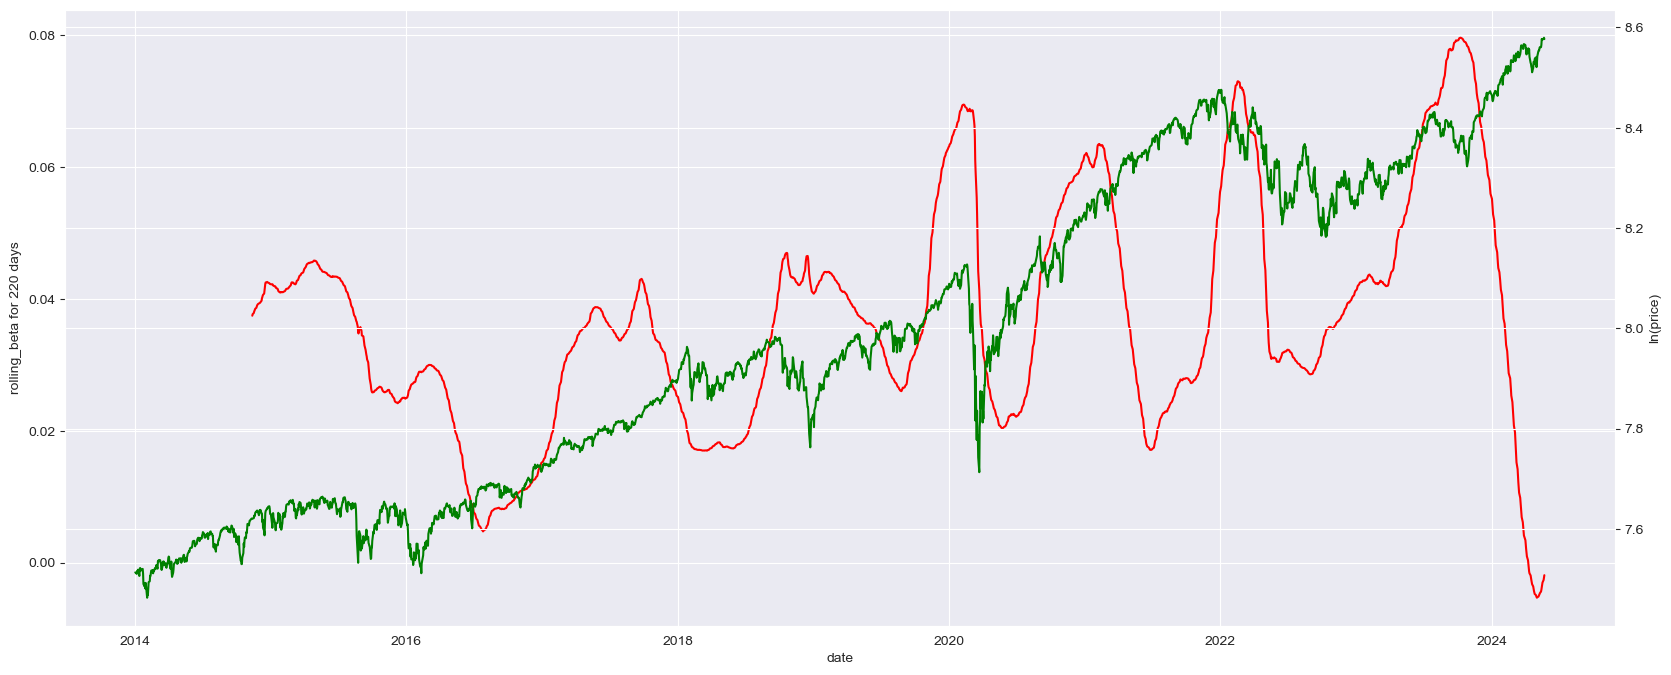

In [33]:
fig, ax1 = plt.subplots(figsize=(20, 8))
sns.lineplot(aapl_sp500_beta, x='date', y='rolling_beta for 220 days', ax=ax1, color='red')
ax2 = ax1.twinx()
sns.lineplot(data_price_sp500, x='date', y='ln(price)', color='green')

In [27]:
aapl_sp500_correlation = count_correlation(aapl, data_price_sp500, 'AAPL', 'SPX500', 220, date1='2010-07-18', date2='2025-02-10', between='price')
aapl_sp500_correlation

,date,price AAPL,price SPX500,rolling correlation
0,2014-01-02,19.7546,"1,832.0000",NaN
1,2014-01-03,19.3207,"1,831.4000",NaN
2,2014-01-06,19.4261,"1,826.8000",NaN
3,2014-01-07,19.2871,"1,837.9000",NaN
4,2014-01-08,19.4093,"1,837.5000",NaN
...,...,...,...,...
2610,2024-05-16,189.8400,"5,297.1000",-0.1262
2611,2024-05-17,189.8700,"5,303.2700",-0.1141
2612,2024-05-20,191.0400,"5,308.1300",-0.1001
2613,2024-05-21,192.3500,"5,321.4100",-0.0851


In [28]:
print(aapl_sp500_correlation.columns)


Index(['date', 'price AAPL', 'price SPX500', 'rolling correlation '], dtype='object')


<Axes: xlabel='date', ylabel='ln(price)'>

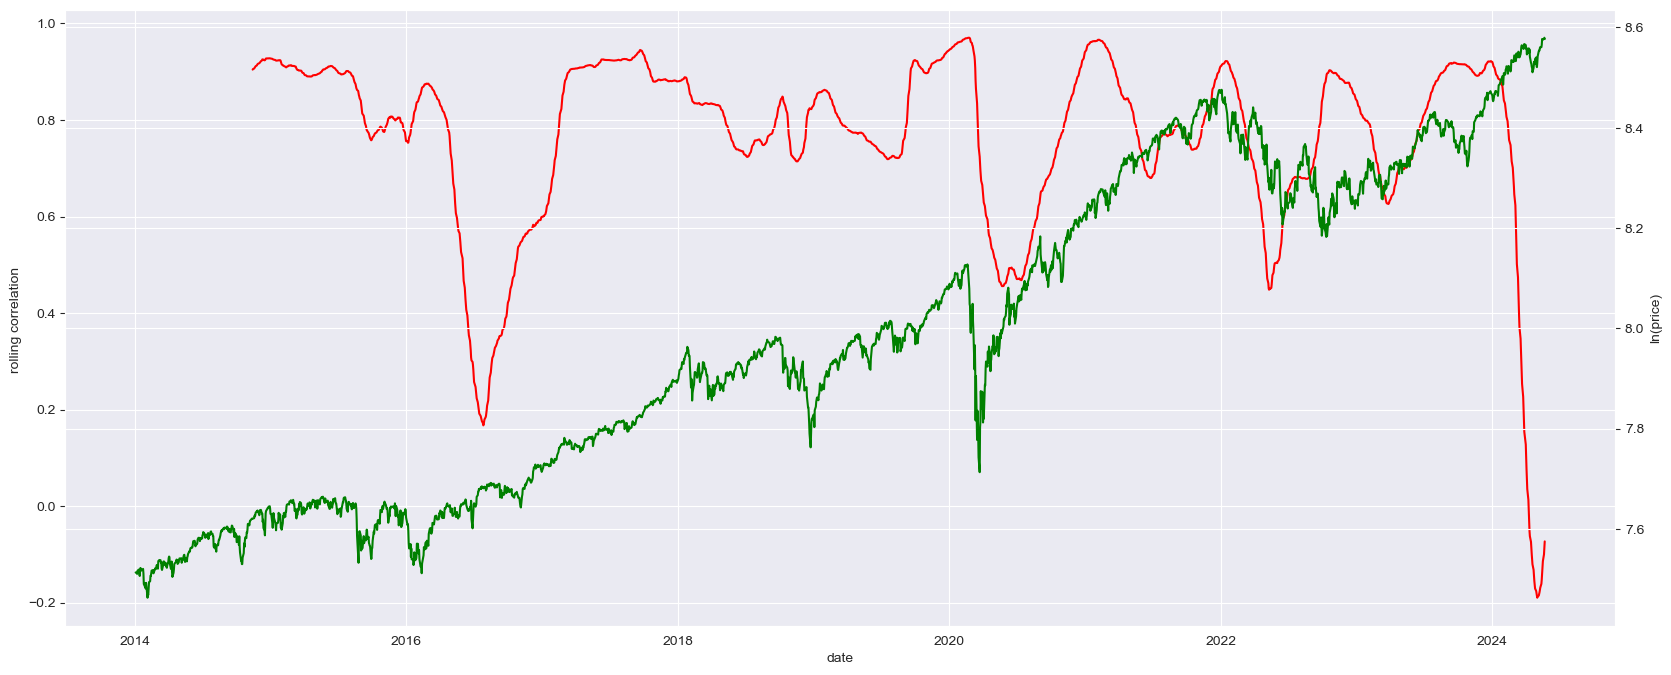

In [29]:
fig, ax1 = plt.subplots(figsize=(20, 8))
sns.lineplot(aapl_sp500_correlation, x='date', y='rolling correlation ', ax=ax1, color='red')
ax2 = ax1.twinx()
sns.lineplot(data_price_sp500, x='date', y='ln(price)', color='green')

In [30]:
aapl_sp500_outperform = count_outperform(aapl, data_price_sp500, '2010-01-01', '2030-01-01', 'AAPL', 'SPX500', 220, 'price')

In [31]:
aapl_sp500_outperform

,date,price AAPL,price SPX500,normalized price AAPL,normalized price SPX500,reset_date,outperform
0,2014-01-02,19.7546,"1,832.0000",1.0000,1.0000,NaN,1.0000
1,2014-01-03,19.3207,"1,831.4000",0.9780,0.9997,NaN,0.9784
2,2014-01-06,19.4261,"1,826.8000",0.9834,0.9972,NaN,0.9862
3,2014-01-07,19.2871,"1,837.9000",0.9763,1.0032,NaN,0.9732
4,2014-01-08,19.4093,"1,837.5000",0.9825,1.0030,NaN,0.9796
...,...,...,...,...,...,...,...
2610,2024-05-16,189.8400,"5,297.1000",1.0698,1.1936,NaN,0.8963
2611,2024-05-17,189.8700,"5,303.2700",1.0700,1.1950,NaN,0.8954
2612,2024-05-20,191.0400,"5,308.1300",1.0766,1.1961,NaN,0.9001
2613,2024-05-21,192.3500,"5,321.4100",1.0840,1.1991,NaN,0.9040


<Axes: xlabel='date', ylabel='outperform'>

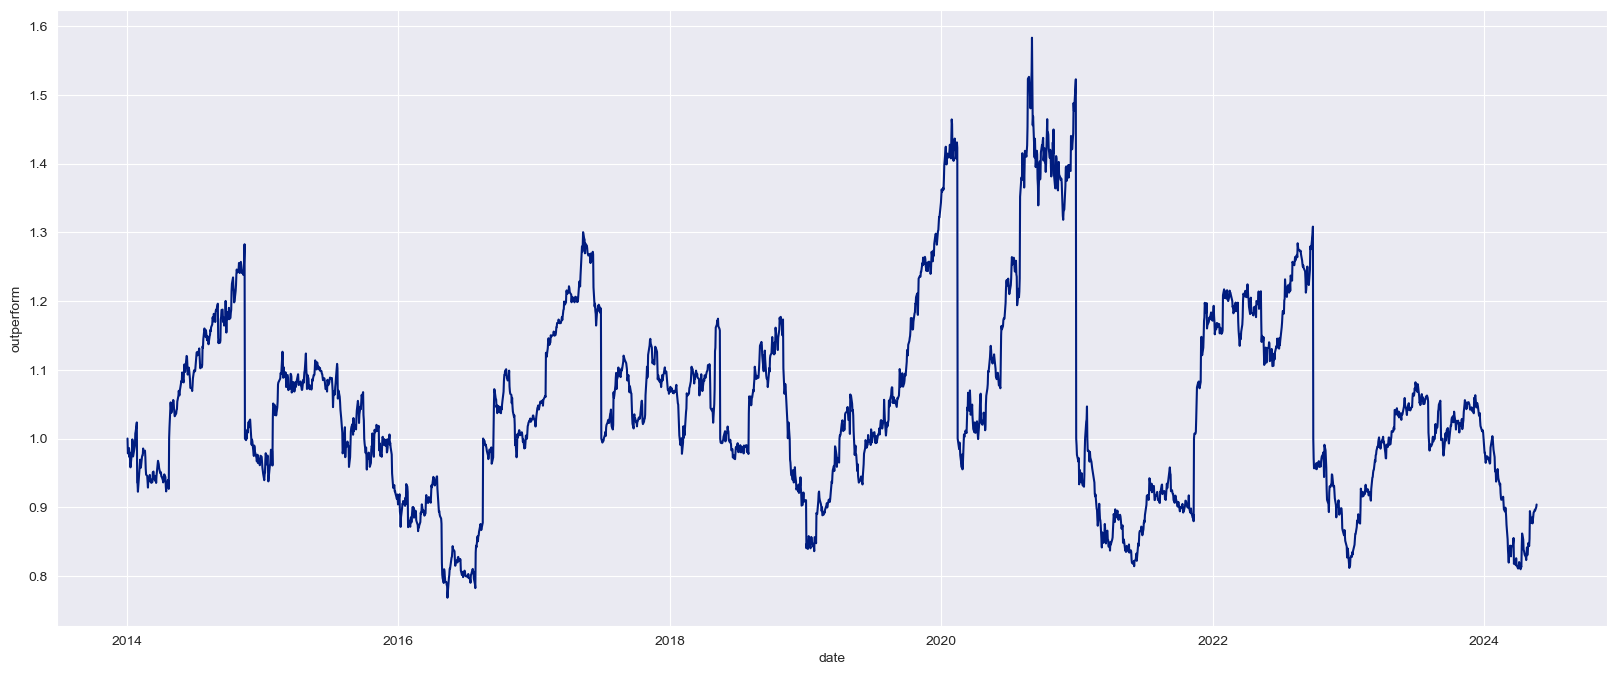

In [32]:
plt.figure(figsize=(20, 8))
sns.lineplot(aapl_sp500_outperform, x='date', y='outperform')

In [34]:
# ПАРСИМ ВИКПЕДИЮ чобы достать сектора для крупнеших компаний (80% всей капитализации наи рынке)
# URL страницы Wikipedia с составом S&P 500
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
# Чтение таблиц с страницы
tables = pd.read_html(url)
# Первая таблица содержит список компаний
sp500_table = tables[0]
df_sector=sp500_table[['Symbol','GICS Sector']]
df_sector

,Symbol,GICS Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care
3,ABBV,Health Care
4,ACN,Information Technology
...,...,...
498,XYL,Industrials
499,YUM,Consumer Discretionary
500,ZBRA,Information Technology
501,ZBH,Health Care


In [38]:

len(set(df_sector['Symbol'])&set(data_price_sp500.columns))

151

In [39]:
df_filtered_sector = df_sector[df_sector['Symbol'].isin(data_price_sp500.columns)]
df_filtered_sector

,Symbol,GICS Sector
5,ADBE,Information Technology
6,AMD,Information Technology
11,ABNB,Consumer Discretionary
12,AKAM,Information Technology
15,ALGN,Health Care
...,...,...
494,WTW,Financials
495,WDAY,Information Technology
496,WYNN,Consumer Discretionary
497,XEL,Utilities


получился датафрейм с 151 компанией, для которых мы знаем сектор (я пытался разными способами еще найти инфы, но зачастую доступ платный и нельзя все нормально выгрузить(((). Далее будем пытаться как-то расширить этот список вручную или с помощью корреляции.

In [43]:
data=data_price_sp500

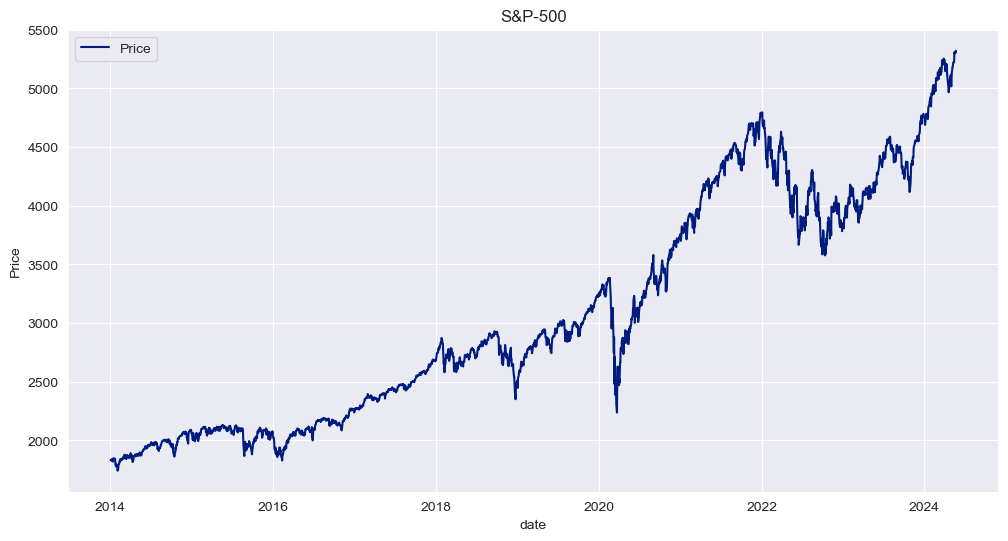

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['price'], label='Price')
plt.xlabel('date')
plt.ylabel('Price')
plt.title('S&P-500')
plt.legend()
plt.show()

Динамика роста S&P-500. Факты - 
1) S&P-500 - взвешенная по капитализации стоимость 500 крупнейшних американских компаний. Вес каждой компании = (капитализация компании)/(сумма капитализаций всех компаний в индексе).
2) c 2014 по 2015 года индекс вырос в 2.2 раза
3) на графике динамики индекса явно выражены кризис связанный с эпидемией covid-19 и кризис 2022-2024 (видимо, геополитика)


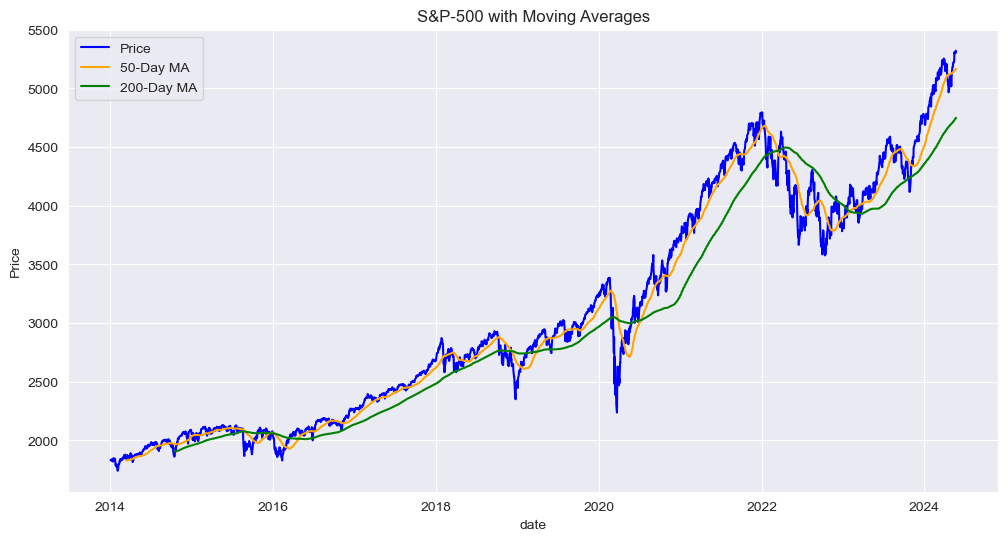

In [46]:

data['MA_50'] = data['price'].rolling(window=50).mean()
data['MA_200'] = data['price'].rolling(window=200).mean()

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['price'], label='Price', color='blue')
plt.plot(data['date'], data['MA_50'], label='50-Day MA', color='orange')
plt.plot(data['date'], data['MA_200'], label='200-Day MA', color='green')
plt.xlabel('date')
plt.ylabel('Price')
plt.title('S&P-500 with Moving Averages')
plt.legend()
plt.show()

Скользящая средняя сглаживает краткосрочные колебания и явно отражает основные циклы и тренды

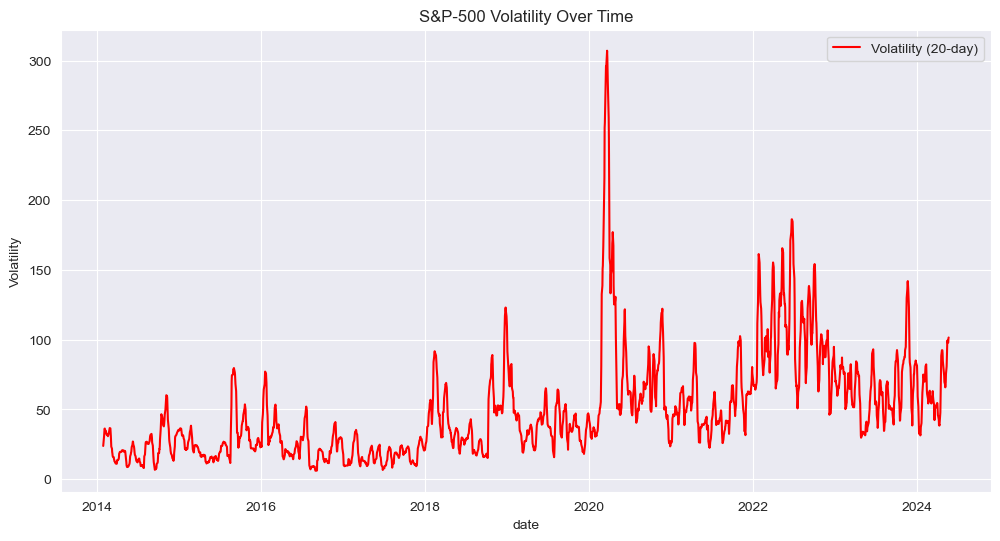

In [48]:

window = 20 
data['Volatility'] = data['price'].rolling(window=window).std()

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['Volatility'], label='Volatility (20-day)', color='red')
plt.xlabel('date')
plt.ylabel('Volatility')
plt.title('S&P-500 Volatility Over Time')
plt.legend()
plt.grid(True)
plt.show()

Высокие значения волатильности указывают на периоды высокой нестабильности цен, а низкие значения — на периоды стабильности. Как мы видим - периоду 2020-2024 харакетрны скачки волатильности, что говорит об экономической неустойчивости в это время

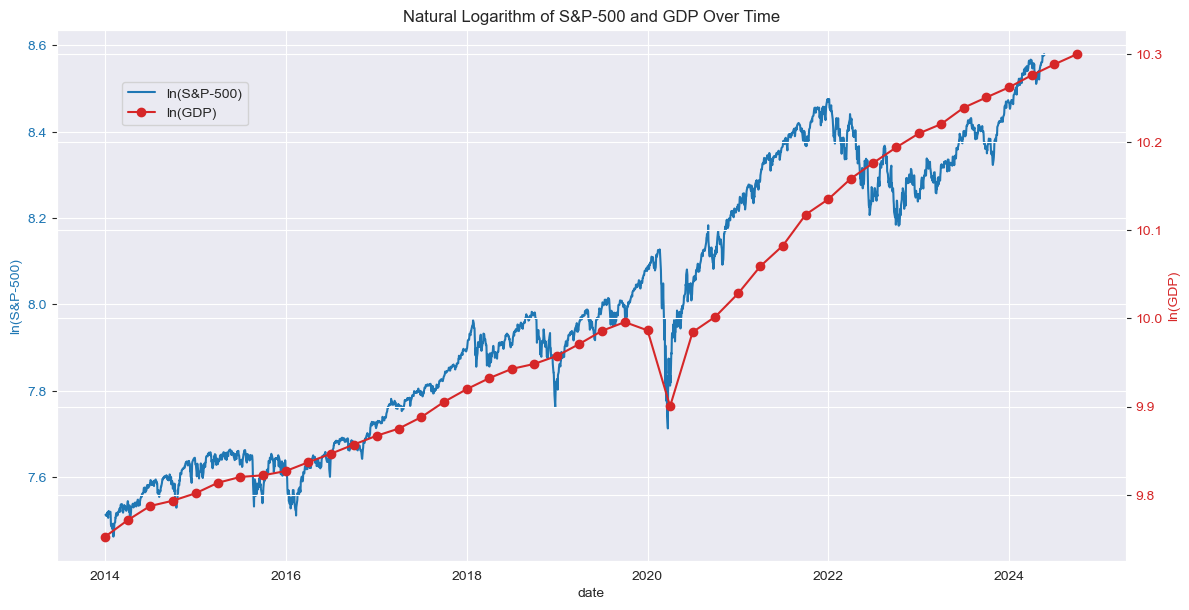

Correlation between ln(S&P-500) and ln(GDP): 0.97


In [50]:
GDP = pd.read_csv('GDP.csv')


GDP['observation_date'] = pd.to_datetime(GDP['observation_date'])

data['date'] = pd.to_datetime(data['date'])

data['ln_price'] = np.log(data['price'])
GDP['ln_GDP'] = np.log(GDP['GDP'])

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel('ln(S&P-500)', color=color)
ax1.plot(data['date'], data['ln_price'], color=color, label='ln(S&P-500)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('ln(GDP)', color=color)
ax2.plot(GDP['observation_date'], GDP['ln_GDP'], color=color, label='ln(GDP)', marker='o')  # Маркеры для точек ВВП
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Natural Logarithm of S&P-500 and GDP Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45)  # Поворот меток для лучшей читаемости
plt.show()


merged_data = pd.merge(data, GDP, left_on='date', right_on='observation_date', how='inner')
correlation = merged_data['ln_price'].corr(merged_data['ln_GDP'])
print(f"Correlation between ln(S&P-500) and ln(GDP): {correlation:.2f}")

График сравнивает ВВП США и S@P-500. Интересный момент  - с 2022 по 2024 S@P-500 падает, ВВП растет, что указывает что кризис был в финансовом секторе и он не отразился на производстве

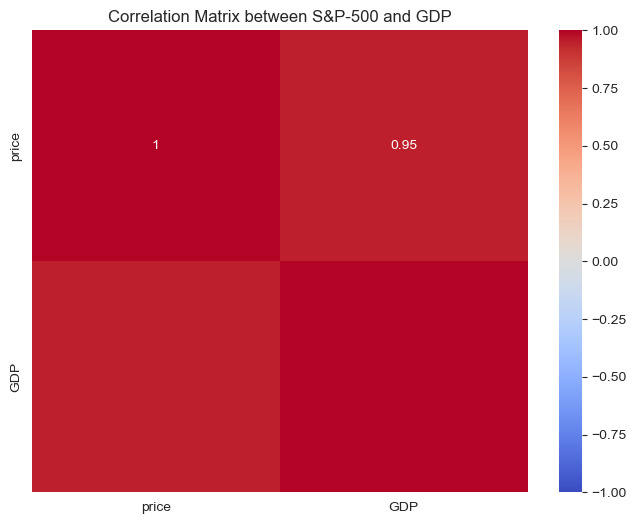

In [52]:
data['date'] = pd.to_datetime(data['date'])
data['Quarter'] = data['date'].dt.to_period('Q') 
sp500_quarterly = data.groupby('Quarter')['price'].mean().reset_index()  

GDP['observation_date'] = pd.to_datetime(GDP['observation_date'])
GDP['Quarter'] = GDP['observation_date'].dt.to_period('Q')

merged_data = pd.merge(sp500_quarterly, GDP, on='Quarter')

correlation_data = merged_data[['price', 'GDP']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between S&P-500 and GDP')
plt.show()


Как мы видим, связь между ВВП и индексом S&P-500 практически линейная, корреляция сильно близка к 1

In [53]:
data.describe()

,date,NaN,AACG,AACI,AADI,AAGR,AAL,AAME,AAOI,AAON,...,open,high,low,volume,change,ln(price),MA_50,MA_200,Volatility,ln_price
count,2615,"2,615.0000","2,615.0000","2,615.0000","2,615.0000","2,615.0000","2,615.0000","2,615.0000","2,615.0000","2,615.0000",...,"2,615.0000","2,615.0000","2,615.0000",0.0000,"2,615.0000","2,615.0000","2,566.0000","2,416.0000","2,596.0000","2,615.0000"
mean,2019-03-12 21:41:13.881453312,10.2334,2.9292,9.8803,39.2286,6.7868,30.2631,3.1470,17.4147,32.8225,...,"3,082.9363","3,099.3798","3,065.3357",NaN,0.0465,7.9854,"3,075.5813","3,057.1650",49.0586,7.9854
min,2014-01-02 00:00:00,0.3740,0.6700,9.3400,1.5900,0.3000,9.0400,1.5000,1.5000,11.3133,...,"1,743.8000","1,755.8000","1,737.9000",NaN,-11.9800,7.4627,"1,828.8460","1,905.7500",5.9948,7.4627
25%,2016-08-06 12:00:00,12.0500,1.3100,9.7500,13.1300,7.0251,16.2350,2.4500,8.4500,18.5467,...,"2,139.6000","2,148.8000","2,131.6500",NaN,-0.3800,7.6683,"2,152.9530","2,196.1472",22.8034,7.6683
50%,2019-03-14 00:00:00,12.0500,2.6300,9.7500,30.7500,7.0251,31.8000,3.2000,12.7200,28.5467,...,"2,831.4000","2,845.6000","2,817.4000",NaN,0.0600,7.9492,"2,838.9910","2,790.5710",39.0345,7.9492
75%,2021-10-14 12:00:00,12.0500,4.4400,9.7500,67.5000,7.0251,41.9050,3.8800,20.5350,42.4733,...,"3,983.7650","4,014.7650","3,953.2850",NaN,0.5700,8.2902,"3,981.6925","3,975.9488",64.9014,8.2902
max,2024-05-22 00:00:00,12.0500,14.3000,11.9800,75.0000,7.7728,58.4700,6.5300,99.6100,94.4700,...,"5,319.2800","5,325.4900","5,302.4000",NaN,9.3800,8.5795,"5,167.5402","4,749.6906",307.0460,8.5795
std,NaN,3.9518,1.6340,0.3326,26.3686,1.3140,13.5162,0.8457,15.2794,17.4714,...,966.9944,972.8637,961.2164,NaN,1.1047,0.3106,942.2138,881.1887,37.2995,0.3106
